## PREDICTION
### data description:
* 160 features extracted from Google trends
* *year* and *state_id* feature that let us take advantage of time and location of the state
* *latitude* and *longitude* features that we are able to use to specify geographical position more explicitly
* *income* and *employment* from US Census Bureau
* percentage of people without health insurance
* two target values: *crude prevalence*, *age-adjusted prevalence*

### model selection:
**Elastic net:** Giving the way we selected features the obtained matrix has a lot of redundant information. Hence, in order to prevent overfitting, we were forced to choose a model with some regulation components. The most popular of them are Ridge and Lasso regression or elastic net technique which is a linear regression with combined L1 and L2 priors as regularizers.

With Elastic net we could also use Elastic net  mixing parameter, with $0 <= l1ratio <= 1$. 
* For $l1ratio = 0$ the penalty is an $L2$ penalty
* For $l1ratio = 1$ it is an $L1$ penalty
* For $0 < l1ratio < 1$, the penalty is a combination of $L1$ and $L2$
### temporal cross-validation
For temporal cross validation we were picking each year and treated the corresponding data as a test set and the rest of the data as a train data.
### spatial cross-validation
For spacial cross-validation we were randomely choosing a group of states and used them as a test set and the rest of the dataset as a train set.
### general cross-validation 
In order to make sure that our result isn't biased in any way we made function *try_model()* which performs following steps:
1. it separates 20 % of the data as a test set
2. does greed search on the train set in order to choose proper alpha (penalty term) and l1 (mixing parameter) and verifies it with 3-folds cross-validation
3. reports the $R^2$ of the test set
4. repeats steps 1-3 several time in order to give information about the variability of the result


In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from scipy import stats
from collections import Counter

In [99]:
def routine_grid(model, parameters, X_train,y_train,X_test,y_test):
    grid = GridSearchCV(model, parameters, scoring="r2", cv=3)
    grid.fit(X_train,y_train)
    
    model = grid.best_estimator_
    model.fit(X_train, y_train)  
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    
    return model, train_score, test_score

def scorer(model, X, y):
    e = 1 - np.sum( (model.predict(X) - y)**2) / np.sum((y.mean() - y)**2 )
    return e

def try_model(X,y,alphas,ls, iters = 15):
    models = []
    train_scores = []
    test_scores =[]
    for i in range(iters): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1000))
        #model = ElasticNet(random_state=0, fit_intercept = True, normalize = True, max_iter= 10000)
        model = ElasticNet(random_state=0, max_iter= 100000)
        par = {"alpha": alphas,
                     "l1_ratio": ls }
        model_best, best_score, test_score = routine_grid(model,par,X_train,y_train,X_test,y_test)
        models.append(model_best)
        train_scores.append(best_score)
        test_scores.append(test_score)
        print(test_score)
    return(models, train_scores, test_scores)


def try_model_space(matrix_df, X, alphas, ls, flag="c", n=10, size=8):
    models = []
    train_scores = []
    test_scores =[]
    iters=matrix_df.index
    for i in range(n):
        cols=np.random.choice(iters, size=size, replace=False)
        X_train=X.drop(cols, inplace=False)
        if flag=="c":
            y_train=matrix_df.drop(cols, inplace=False)["prevalence_c"]
        else:
            y_train=matrix_df.drop(cols, inplace=False)["prevalence_a"]

        X_test=X.loc[cols]
        if flag=="c":
            y_test=matrix_df.loc[cols]["prevalence_c"]
        else:
            y_test=matrix_df.loc[cols]["prevalence_a"]
        #model = ElasticNet(random_state=0, fit_intercept = True, normalize = True, max_iter= 10000)
        #print(y_test.index, X_test.index)
        scaler = StandardScaler() #standardize features by removing the mean and scaling to unit variance
        X_train=scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = ElasticNet(random_state=0, max_iter= 100000)
        par = {"alpha": alphas,
                     "l1_ratio": ls }
        model_best, best_score, test_score = routine_grid(model,par,X_train,y_train,X_test,y_test)
        models.append(model_best)
        train_scores.append(best_score)
        test_scores.append(test_score)
        print(cols, test_score)
    return(models, train_scores, test_scores)

def try_model_time(matrix_df, X, alphas, ls, flag="c"):
    models = []
    train_scores = []
    test_scores =[]
    iters=[2011, 2012, 2013, 2014, 2015, 2016]
    for i in iters:
        X_train=pd.DataFrame()
        y_train=pd.DataFrame()
        for j in iters:
            if j != i:
                X_temp=X[X["year"]==j]
                if flag=="c":
                    y_temp=matrix_df[matrix_df["year"]==j]["prevalence_c"]
                else:
                    y_temp=matrix_df[matrix_df["year"]==j]["prevalence_a"]
                X_train=pd.concat([X_train, X_temp], axis=0)
                y_train=pd.concat([y_train, y_temp], axis=0)

        X_test=X[X["year"]==i]
        if flag == "c":
            y_test=matrix_df[matrix_df["year"]==i]["prevalence_c"]
        else:
            y_test=matrix_df[matrix_df["year"]==i]["prevalence_a"]
        #labels = X.columns
        scaler = StandardScaler() #standardize features by removing the mean and scaling to unit variance
        X_train=scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = ElasticNet(random_state=0, max_iter= 100000)
        par = {"alpha": alphas,
                     "l1_ratio": ls }
        model_best, best_score, test_score = routine_grid(model,par,X_train,y_train,X_test,y_test)
        models.append(model_best)
        train_scores.append(best_score)
        test_scores.append(test_score)
        print(i, test_score)
    return(models, train_scores, test_scores)

def show_coefs(model,X):
    plt.figure(figsize=(20,10))
    coef = pd.Series(model.coef_, index = X.columns).sort_values()
    imp_coef = pd.concat([coef.head(10), coef.tail(10)])
    imp_coef.plot(kind = "barh")
    plt.title("Coefficients in the Model")
    plt.show()

In [3]:
matrix_df=pd.read_csv("../data/matrix/matrix_df_163.csv", index_col=0)
matrix_df = matrix_df.fillna(matrix_df.mean())
results = dict()
matrix_df.shape

(306, 163)

## 2.1 spatial and temporal cross-validation

In [4]:
y_a = matrix_df["prevalence_a"]
y_c = matrix_df["prevalence_c"]
X = matrix_df.drop(["prevalence_a","prevalence_c","income","insurance", "unemployment"], axis =1)


### spatial cross-validation for crude prevalence

In [22]:
alphas = np.array([0.0001,  0.001,  0.01 ,  0.1, 1.0,1.5,2])
ls = np.arange(0.1, 1.1, 1.0)

models_c_space, train_scores_c_space, test_scores_c_space = try_model_space(matrix_df, X, alphas,ls, flag="c", size=10)    

['West Virginia' 'New Mexico' 'Alabama' 'New Jersey' 'Nebraska' 'Illinois'
 'Ohio' 'Maryland' 'Oregon' 'Arizona'] 0.357747912834
['South Dakota' 'Idaho' 'Rhode Island' 'Kentucky' 'Oregon' 'Georgia'
 'Texas' 'Connecticut' 'West Virginia' 'Texas'] 0.609187920746
['South Carolina' 'Mississippi' 'Colorado' 'North Dakota' 'Arizona'
 'Oklahoma' 'Georgia' 'Montana' 'New Mexico' 'Indiana'] 0.2631174643
['Pennsylvania' 'Rhode Island' 'Maryland' 'Vermont' 'Alabama' 'Minnesota'
 'Louisiana' 'Delaware' 'Indiana' 'Georgia'] 0.599752004041
['New Jersey' 'Indiana' 'Vermont' 'Kentucky' 'Michigan' 'South Carolina'
 'Florida' 'New York' 'Vermont' 'West Virginia'] 0.738213198339
['Montana' 'Mississippi' 'New Hampshire' 'Utah' 'Nevada' 'New Mexico'
 'Kansas' 'Texas' 'North Carolina' 'Tennessee'] 0.289706417047
['Oregon' 'Wisconsin' 'Louisiana' 'California' 'Alabama' 'Idaho'
 'New Mexico' 'North Dakota' 'Delaware' 'Missouri'] 0.334028083633
['Mississippi' 'Delaware' 'Arizona' 'Alabama' 'West Virginia' 'Ari

In [25]:
models_c_space

[ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alph

In [24]:
train_scores_c_space

[0.72273305902444851,
 0.89878253463445978,
 0.77026961802237004,
 0.74379890798834714,
 0.72969826189527986,
 0.76661586256056846,
 0.75316908128133342,
 0.74620351244904448,
 0.76900198936672592,
 0.73242456737922712]

In [23]:
np.mean(test_scores_c_space)

0.42388685955312333

### spatial cross-validation for age-adjasted prevalence

In [41]:
alphas = np.array([0.0001,  0.001,  0.01 ,  0.1, 1.0,1.5,2])
ls = np.arange(0.1, 1, 1.0)

models_a_space, train_scores_a_space, test_scores_a_space = try_model_space(matrix_df, X, alphas,ls, flag="a", size=10)  

['Texas' 'Texas' 'West Virginia' 'North Dakota' 'Texas' 'Tennessee'
 'New Jersey' 'Georgia' 'South Carolina' 'Vermont'] 0.784515974418
['Texas' 'Idaho' 'Mississippi' 'District of Columbia' 'Maine' 'Montana'
 'Wyoming' 'North Dakota' 'Arkansas' 'Utah'] 0.35733612456
['Kansas' 'Mississippi' 'California' 'Ohio' 'Idaho' 'New Mexico' 'Maryland'
 'Kansas' 'Georgia' 'Pennsylvania'] 0.0288470573477
['Washington' 'Alabama' 'Rhode Island' 'West Virginia' 'New York'
 'Tennessee' 'Nevada' 'Florida' 'Delaware' 'New Jersey'] 0.731421208073
['Connecticut' 'Florida' 'Nebraska' 'South Dakota' 'California' 'Missouri'
 'New Mexico' 'North Dakota' 'District of Columbia' 'New Mexico'] 0.0284286977638
['Tennessee' 'District of Columbia' 'Missouri' 'Illinois' 'Connecticut'
 'Hawaii' 'Alaska' 'Nebraska' 'North Dakota' 'Oklahoma'] 0.392455464146
['Illinois' 'Nevada' 'Kansas' 'Georgia' 'Vermont' 'New Hampshire'
 'North Dakota' 'North Carolina' 'Indiana' 'Rhode Island'] 0.380865160914
['North Dakota' 'Wyoming' '

In [42]:
models_a_space

[ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alph

In [43]:
train_scores_a_space

[0.71597839139898689,
 0.77931664034017722,
 0.91423685328160709,
 0.72862557290526975,
 0.9071162190835832,
 0.75724227644925812,
 0.91323941801642183,
 0.90799525485692512,
 0.73107264127955673,
 0.74774358550477538]

In [44]:
np.mean(test_scores_a_space)

0.39470436932217606

## temporal cross-validation for crude prevalence

In [46]:
alphas = np.array([0.0001,  0.001,  0.01 ,  0.1, 1.0])
ls = np.arange(0.1, 1.1, 0.1)

models_c_time, train_scores_c_time, test_scores_c_time = try_model_time(matrix_df, X, alphas,ls, flag="c")    

2011 0.708306694421
2012 0.764374226512
2013 0.716638151965
2014 0.83764587023
2015 0.85930710834
2016 0.603970307626


In [47]:
models_c_time

[ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.59999999999999998, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.40000000000000002, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.20000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
      

In [48]:
train_scores_c_time

[0.90516831426656408,
 0.84229839245733462,
 0.87086277134912282,
 0.88102817858590832,
 0.87978092347258197,
 0.8629377037468815]

In [49]:
test_scores_c_time

[0.70830669442100436,
 0.76437422651170694,
 0.71663815196526892,
 0.83764587022998449,
 0.85930710834010293,
 0.60397030762586512]

## temporal cross-validation for age-adjusted prevalence

In [51]:
alphas = np.array([0.0001,  0.001,  0.01 ,  0.1, 1.0])
ls = np.arange(0.1, 1.1, 0.1)

models_a_time, train_scores_a_time, test_scores_a_time = try_model_time(matrix_df, X, alphas, ls, flag="a")  

2011 0.707682759187
2012 0.795053997426
2013 0.724190785778
2014 0.833628494348
2015 0.856335505098
2016 0.628122433732


In [52]:
models_a_time

[ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.30000000000000004, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.5, max_iter=100000, normalize=False, positive=False,
       precompute=False, random_state=0, selection='cyclic', tol=0.0001,
       warm_start=False),
 ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
       l1_ratio=0.30000000000000004, max_iter=100000, normalize=False,
       positive=False, precompute=False, random_state=0, selection='cyclic',
       tol=0.0001, war

In [53]:
train_scores_a_time

[0.90647632869295192,
 0.86852112574046836,
 0.865728988518909,
 0.8728210749818075,
 0.88160986483073678,
 0.85546859197798952]

In [54]:
test_scores_a_time

[0.70768275918660439,
 0.79505399742649141,
 0.72419078577766971,
 0.83362849434812825,
 0.85633550509813805,
 0.62812243373157095]

As we see temporal cross validation works much better, while prediction for a group of states doesn't seem reliable. We believe that the reason for this is that we don't have very similar states and hense it's complicates to make a decent prediction: 

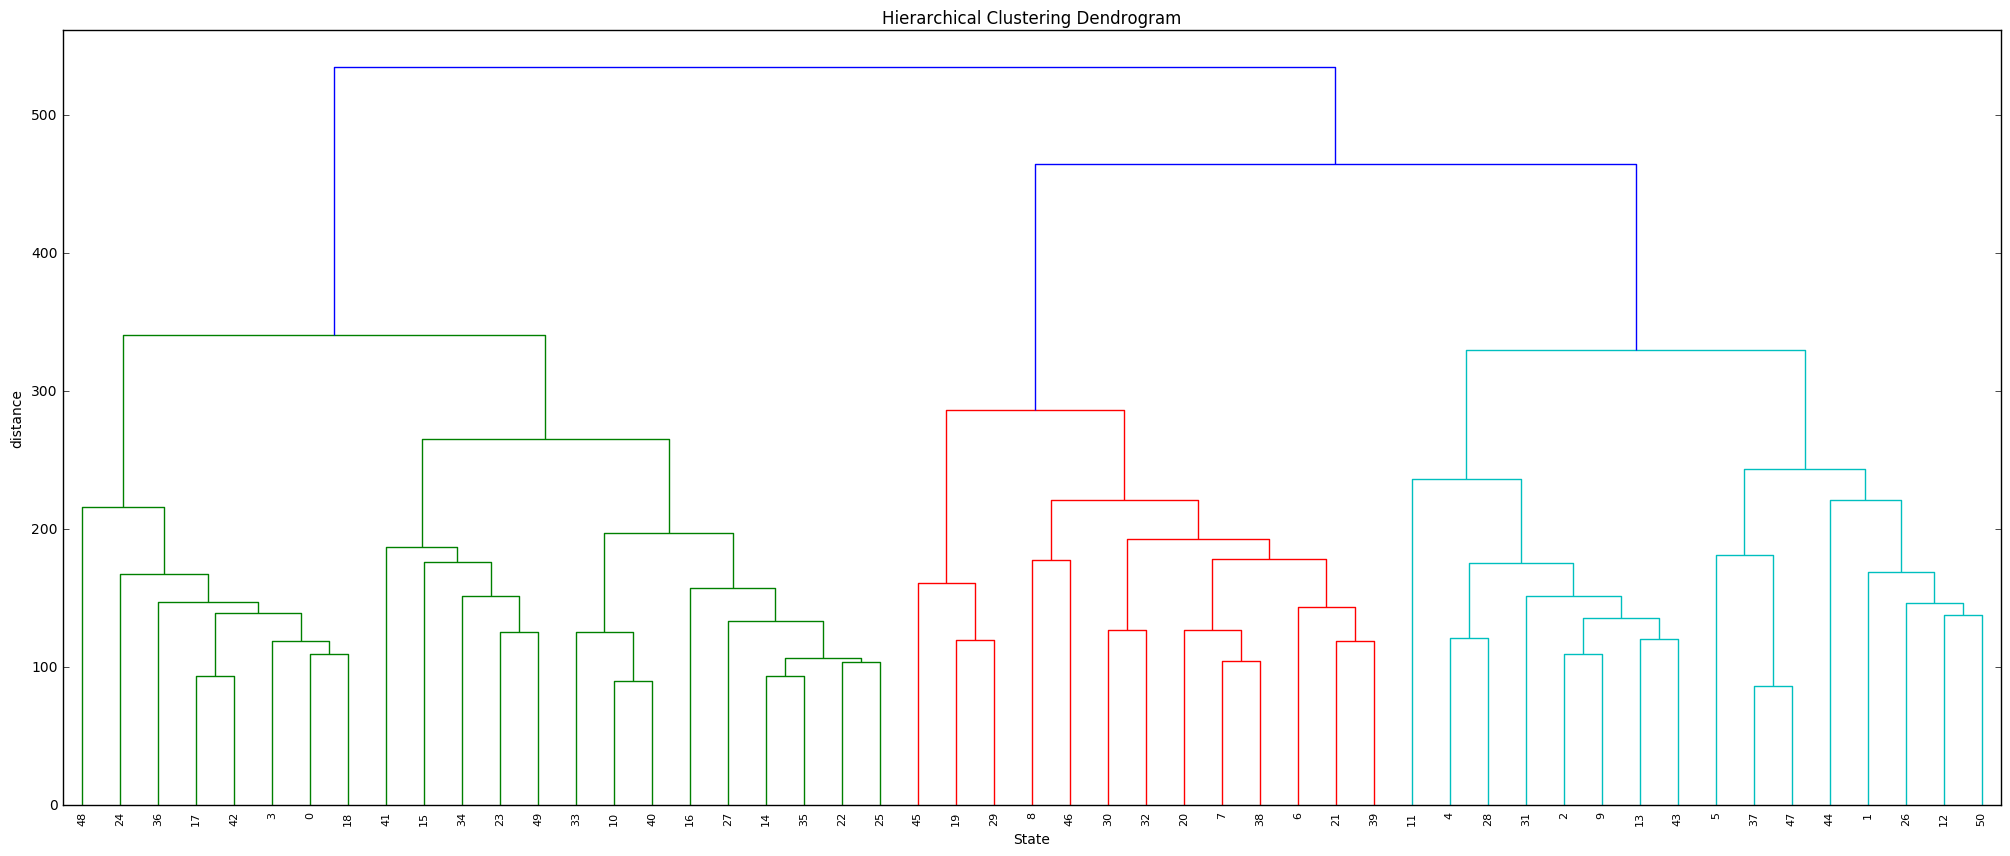

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X[X["year"]==2016], 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('State')
plt.xticks(np.arange(1,len(X.index)),list(X.index),rotation=45 )
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

## 2.2 
Now we would like to switch to the whole dataset in order to see significants of the chosen features. 
Firstly we will performe analysis just for google trends data and then will add census features

### Model for age-adjusted prevalence prediction

In [100]:
y_a = matrix_df["prevalence_a"]
y_c = matrix_df["prevalence_c"]
X = matrix_df.drop(["prevalence_a","prevalence_c","income","insurance", "unemployment"], axis =1)
labels = X.columns
scaler = StandardScaler() #standardize features by removing the mean and scaling to unit variance
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X)
X.columns = labels

alphas = np.array([0.01 ,0.1,0.3,0.5])
ls = np.arange(0.1, 0.4, 0.1)

models_a, train_scores_a, test_scores_a = try_model(X,y_a,alphas,ls, iters = 15)    


0.72671804835
0.657051865675
0.758862162289
0.745023410616
0.797159162655
0.795107894237
0.72117502515
0.793712839754
0.745224696851
0.770516190167
0.742675913726
0.730794005444
0.827058735593
0.774218354997
0.809415391672


In [101]:
results["trends only for age-adj. prev."] = np.mean(test_scores_a)
np.mean(test_scores_a)

0.75964757981184783

In [102]:
data = Counter(models_a)
model = data.most_common(1)[0][0]

In [103]:
model

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.10000000000000001, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=0, selection='cyclic',
      tol=0.0001, warm_start=False)

Let's see what features were selected as the most relevant:

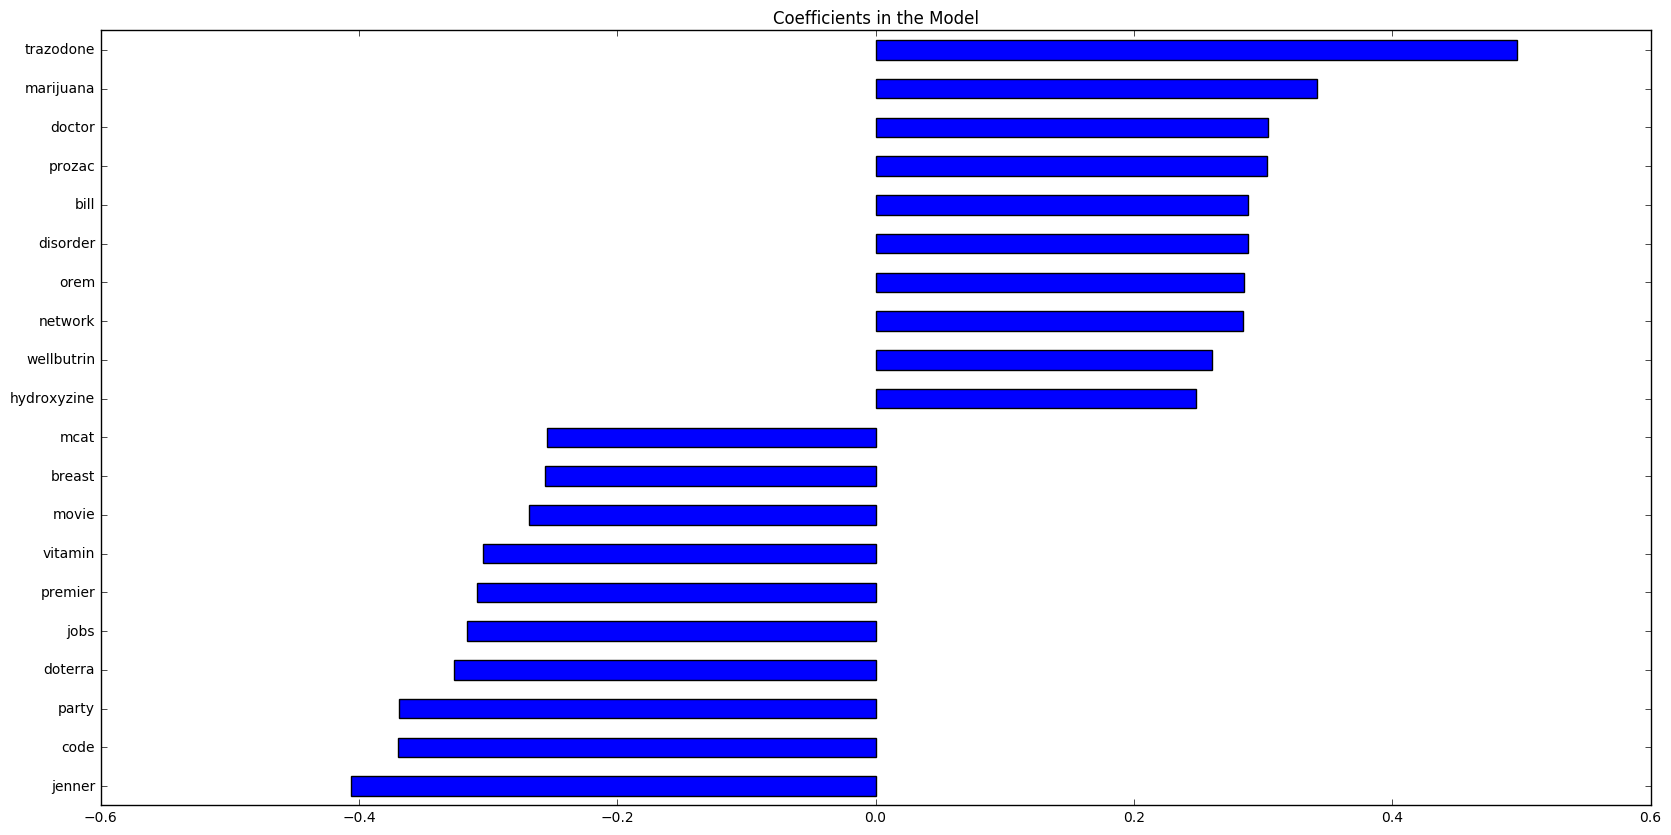

In [104]:
show_coefs(model,X)

The result seems meaningful: as features that correlate positively with depression, we can extract really straight connections. For instance, there are a lot of medicine related terms: doctor, prozac (antidepressant), trazodone (antidepressant), marijuana (used for depression treatment in some states) and so on.

Also, we found interesting that term "orem" appeared to be meaningful. Orem is a city in Utah and Utah is one of the states with a very high level of depression according to ground truth data.

Term "robin" seem meaningless in some sense, but in fact, it refers to a tragic story of comedian Robin Williams who commited suicide because of his depression in August 2014.

In the down part of the plot, we are able to see many positive terms such as vitamin, friends, code, party. Probably, we can conclude from this that people who concerned about these terms don't seem to be interested in depression.


### Model for crude prevalence prediction

In [106]:
models_c, train_scores_c, test_scores_c = try_model(X,y_c,alphas,ls, iters = 15)    

0.725381130799
0.84672645374
0.812874555183
0.725659817394
0.74120999942
0.726459013239
0.827559598017
0.822879987836
0.790336329277
0.828525078694
0.771614547062
0.8130643463
0.84146604384
0.659491476427
0.779261478922


In [107]:
results["trends only for crude prev."] = np.mean(test_scores_c)
np.mean(test_scores_c)

0.78083399041009227

In [108]:
data = Counter(models_c)
model = data.most_common(1)[0][0]
print(model)

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.20000000000000001, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=0, selection='cyclic',
      tol=0.0001, warm_start=False)


As we see, elastic search picked the same values for predicting crude prevalence and this makes sense since as we discovered before, the correlation between these two target features are almost 1.

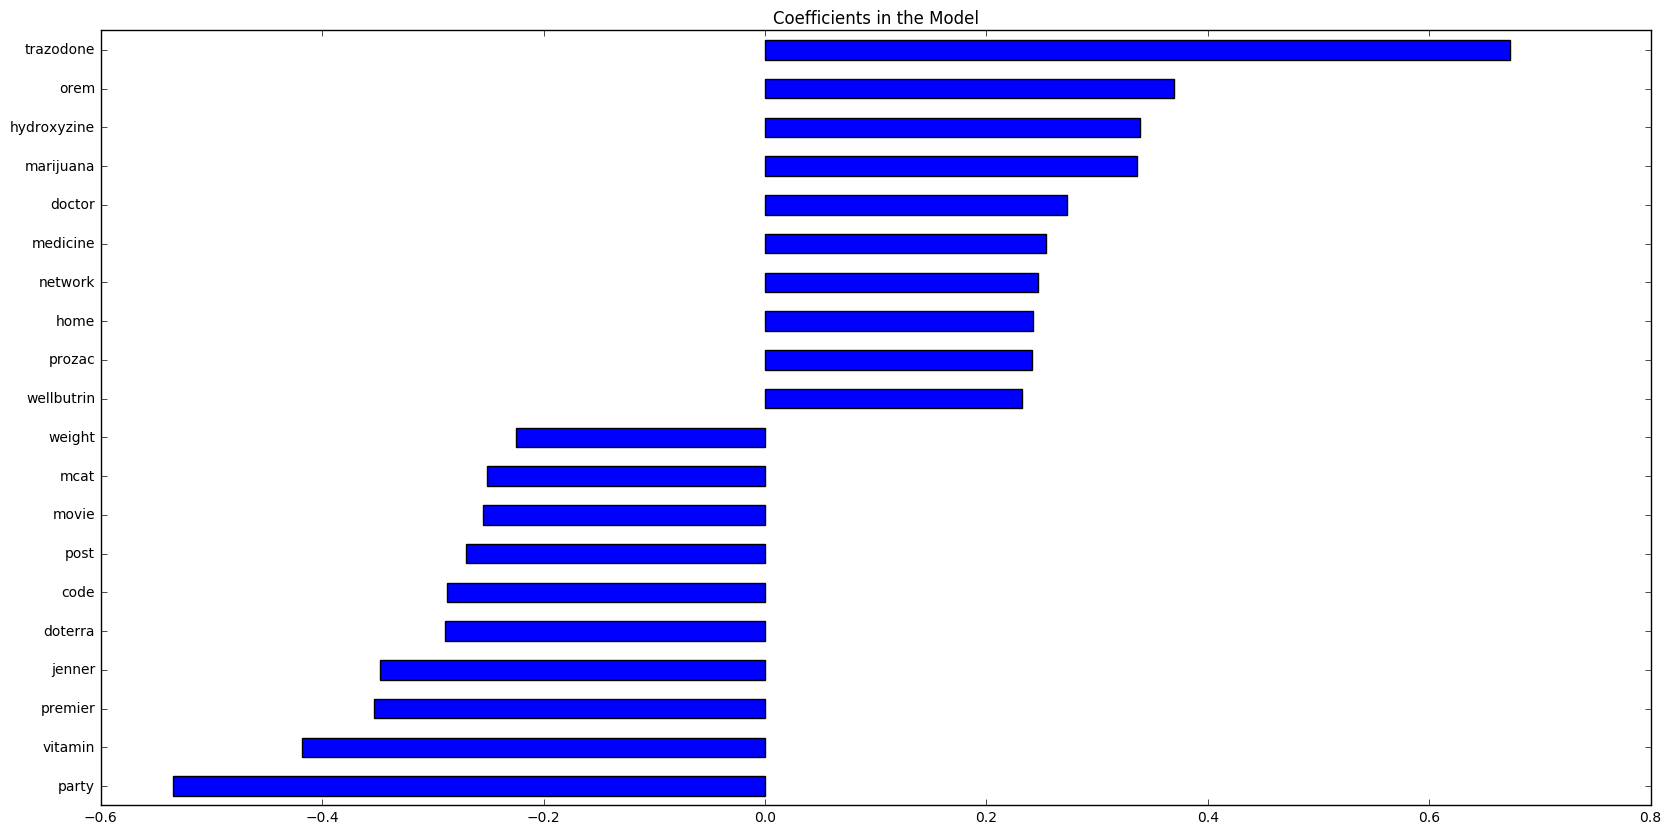

In [109]:
show_coefs(model,X)

The results of the feature selection is more or less the same as for age-adjusted prevalence target value

## 2.2 Google Trends + census features (income and employment) model

### Model for age-adjusted prevalence prediction with census features

In [110]:
X = matrix_df.drop(["prevalence_a","prevalence_c","insurance"], axis =1)
labels = X.columns
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X)
X.columns = labels


In [111]:
models_a, train_scores_a, test_scores_a = try_model(X,y_a,alphas,ls, iters = 15) 

0.731832327482
0.802021799434
0.799860782349
0.779956450306
0.66129441033
0.674742804492
0.794036449741
0.806366498011
0.730969104398
0.717605064342
0.76552437181
0.655645333716
0.795920177355
0.794036449741
0.835173945055


In [112]:
results["trends + census data for age-adj. prev."] = np.mean(test_scores_a)
np.mean(test_scores_a)

0.75633239790408247

In [113]:
data = Counter(models_a)
model = data.most_common(1)[0][0]
print(model)

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.20000000000000001, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=0, selection='cyclic',
      tol=0.0001, warm_start=False)


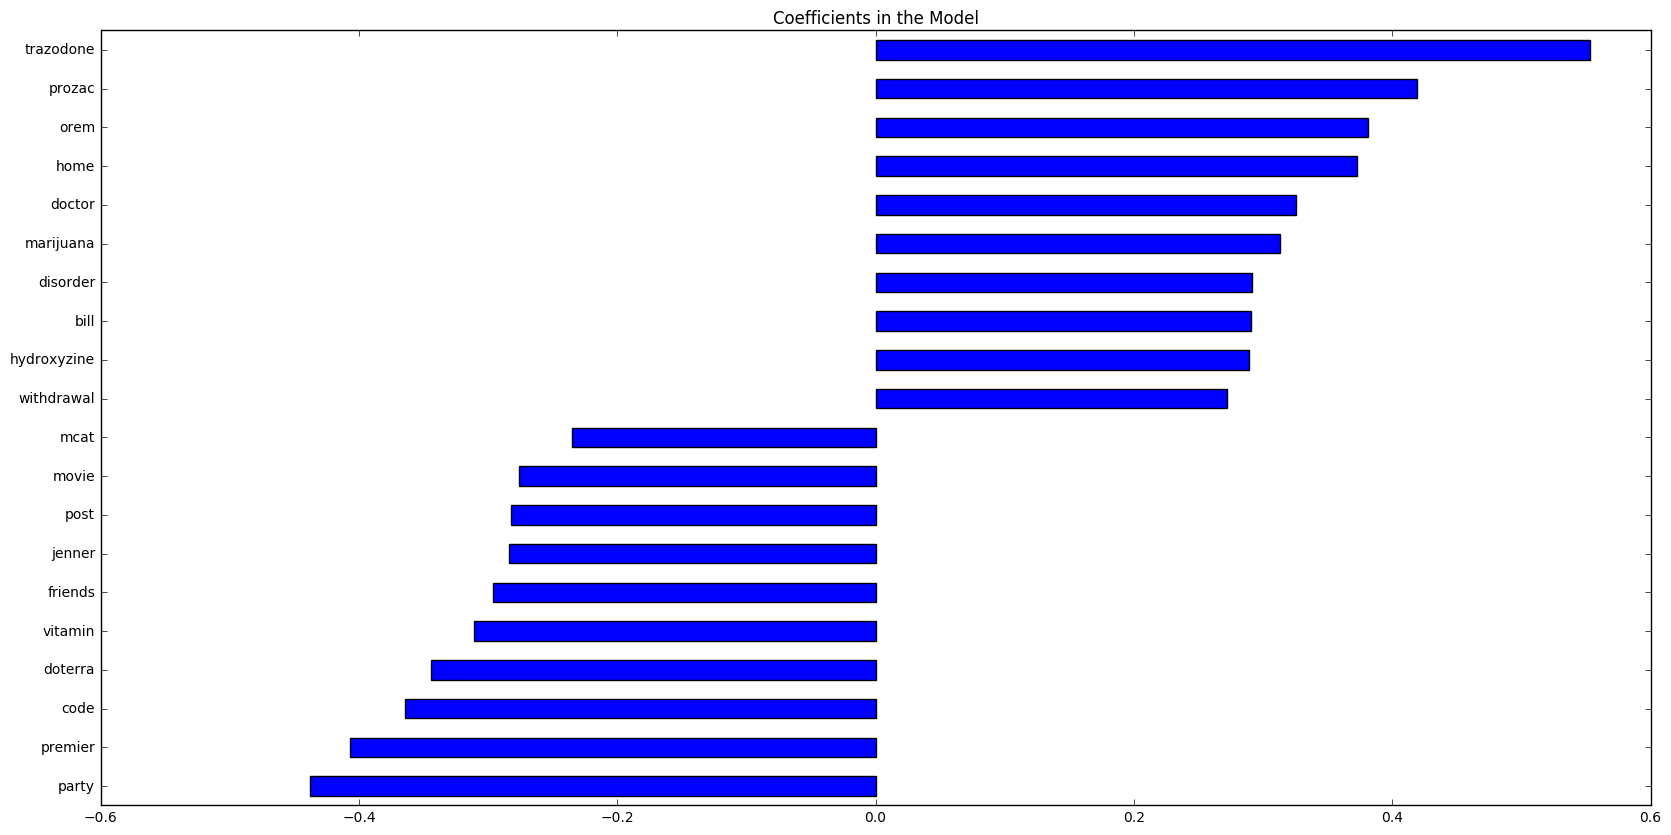

In [114]:
show_coefs(model,X)

As we see, "income" or "emplyment" were not chosen as a significant features.

### Model for crude prevalence prediction with census features

In [115]:
models_c, train_scores_c, test_scores_c = try_model(X,y_c,alphas,ls, iters = 15)  

0.766082831015
0.636753706586
0.709435487312
0.757166722787
0.812826233975
0.849735639745
0.776659947569
0.788030399969
0.740527800976
0.835688537655
0.793780584614
0.662106567864
0.714274496665
0.792565420384
0.686333187423


In [116]:
results["trends + census data for crude prev."] = np.mean(test_scores_c)
np.mean(test_scores_c)

0.75479783763596897

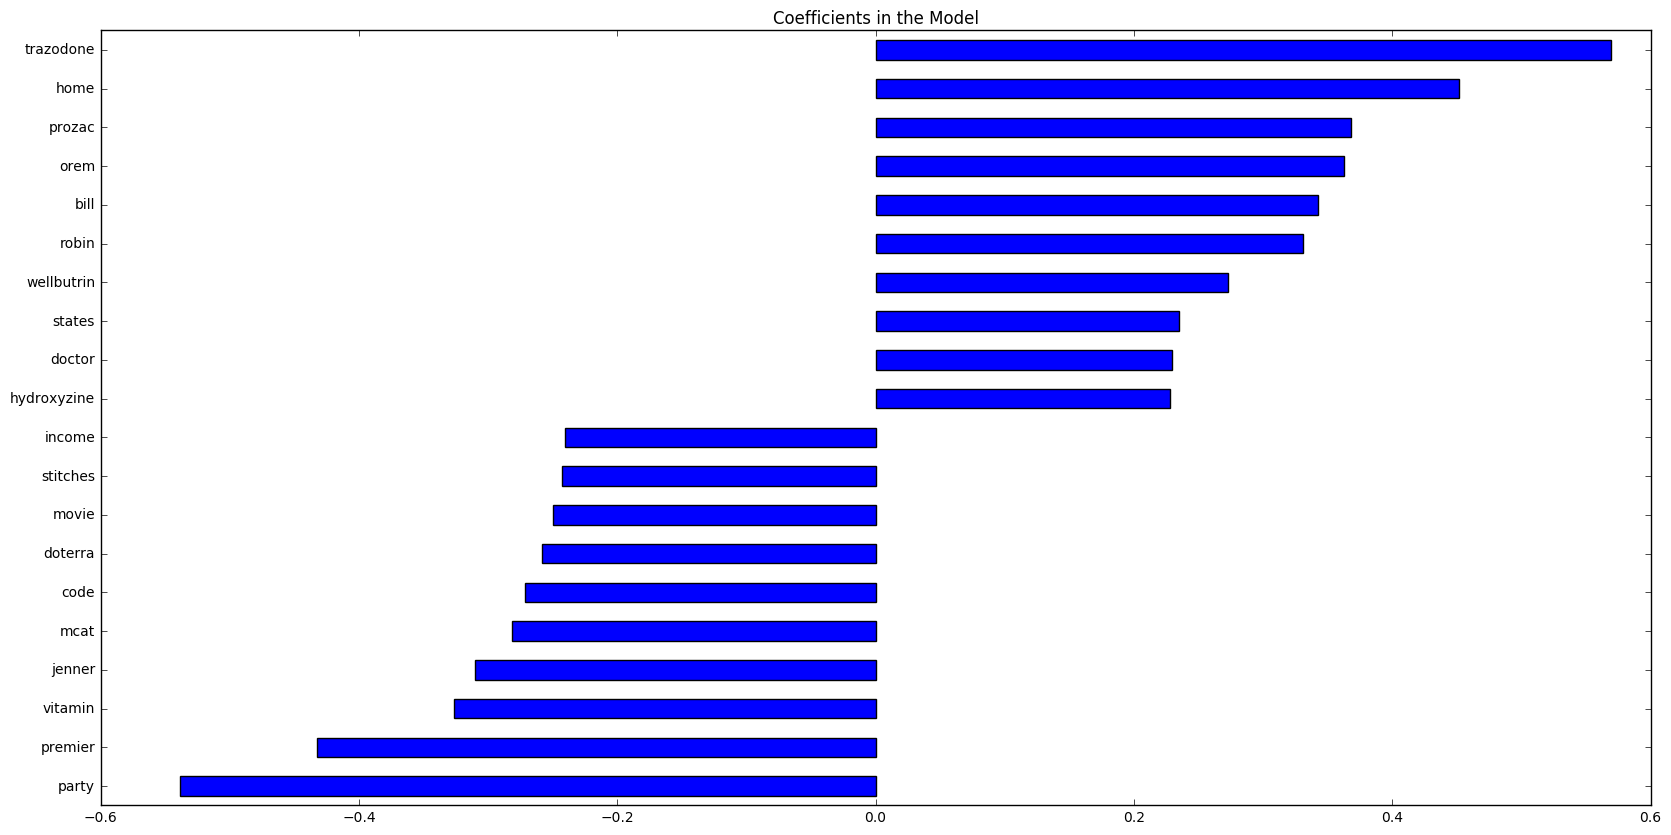

In [117]:
data = Counter(models_c)
model = data.most_common(1)[0][0]
show_coefs(model,X)

An interesting result that for crude prevalence a level of income appeared to be significant. This probably means that the most sensitive to depression group is less depended on the income, while in general, it's a significant factor.

Although adding census features didn't improve the predictions and hence we assume that the level of income doesn't bring any new information comparing to those we extracted from Google Trends.

## 2.3 Google Trends + census features (income and employment) + insurance data model

### Model for age-adjusted prevalence prediction with census features + insurance data

In [118]:
X = matrix_df.drop(["prevalence_a","prevalence_c"], axis =1)
labels = X.columns
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X)
X.columns = labels

In [119]:

models_a, train_scores_a, test_scores_a = try_model(X,y_a,alphas,ls, iters = 15) 

0.722687620699
0.8217331415
0.754771077628
0.695009349262
0.757112309227
0.782366976266
0.837026618165
0.726132088546
0.745066663402
0.816809882372
0.808017369231
0.700517165542
0.835727890697
0.722941786029
0.827571974449


In [120]:
results["trends + census data + insurance data for age-adj. prev."] = np.mean(test_scores_a)
np.mean(test_scores_a)

0.77023279420097235

In [121]:
data = Counter(models_a)
model = data.most_common(1)[0][0]
print(model)

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.30000000000000004, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=0, selection='cyclic',
      tol=0.0001, warm_start=False)


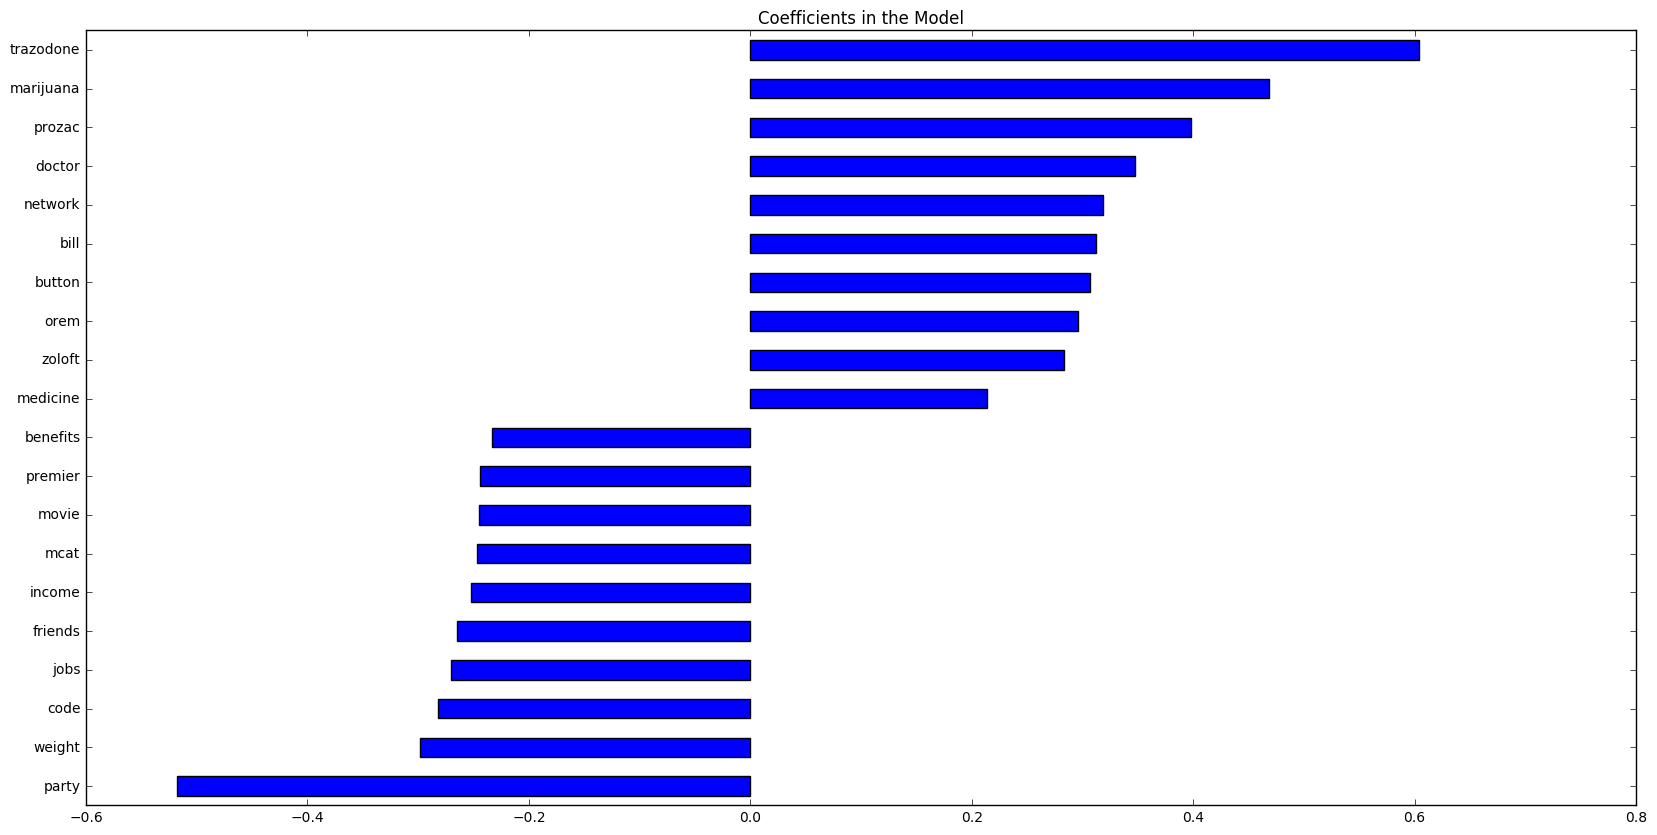

In [122]:
show_coefs(model,X)

Insurance information doesn't seem significant or improving our prediction. 

But this time we see "income" as a significant feature for age-adjusted prevalence. We need to take into account that elastic net has randomness inside and hence the choice of features that have the same explanatory weight might be different.

### Model for crude prevalence prediction with census features + insurance data

In [123]:

models_c, train_scores_c, test_scores_c = try_model(X,y_c,alphas,ls, iters = 15) 

0.788809910628
0.835601127585
0.850309133824
0.827700757966
0.788030478885
0.768398719684
0.827386076379
0.740823923312
0.715469211934
0.741974194118
0.717871305938
0.809081743639
0.82869304308
0.739221035282
0.729879806661


In [124]:
results["trends + census data + insurance data for crude prev."] = np.mean(test_scores_c)
np.mean(test_scores_c)

0.78061669792765942

In [125]:
data = Counter(models_c)
model = data.most_common(1)[0][0]
print(model)

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.30000000000000004, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=0, selection='cyclic',
      tol=0.0001, warm_start=False)


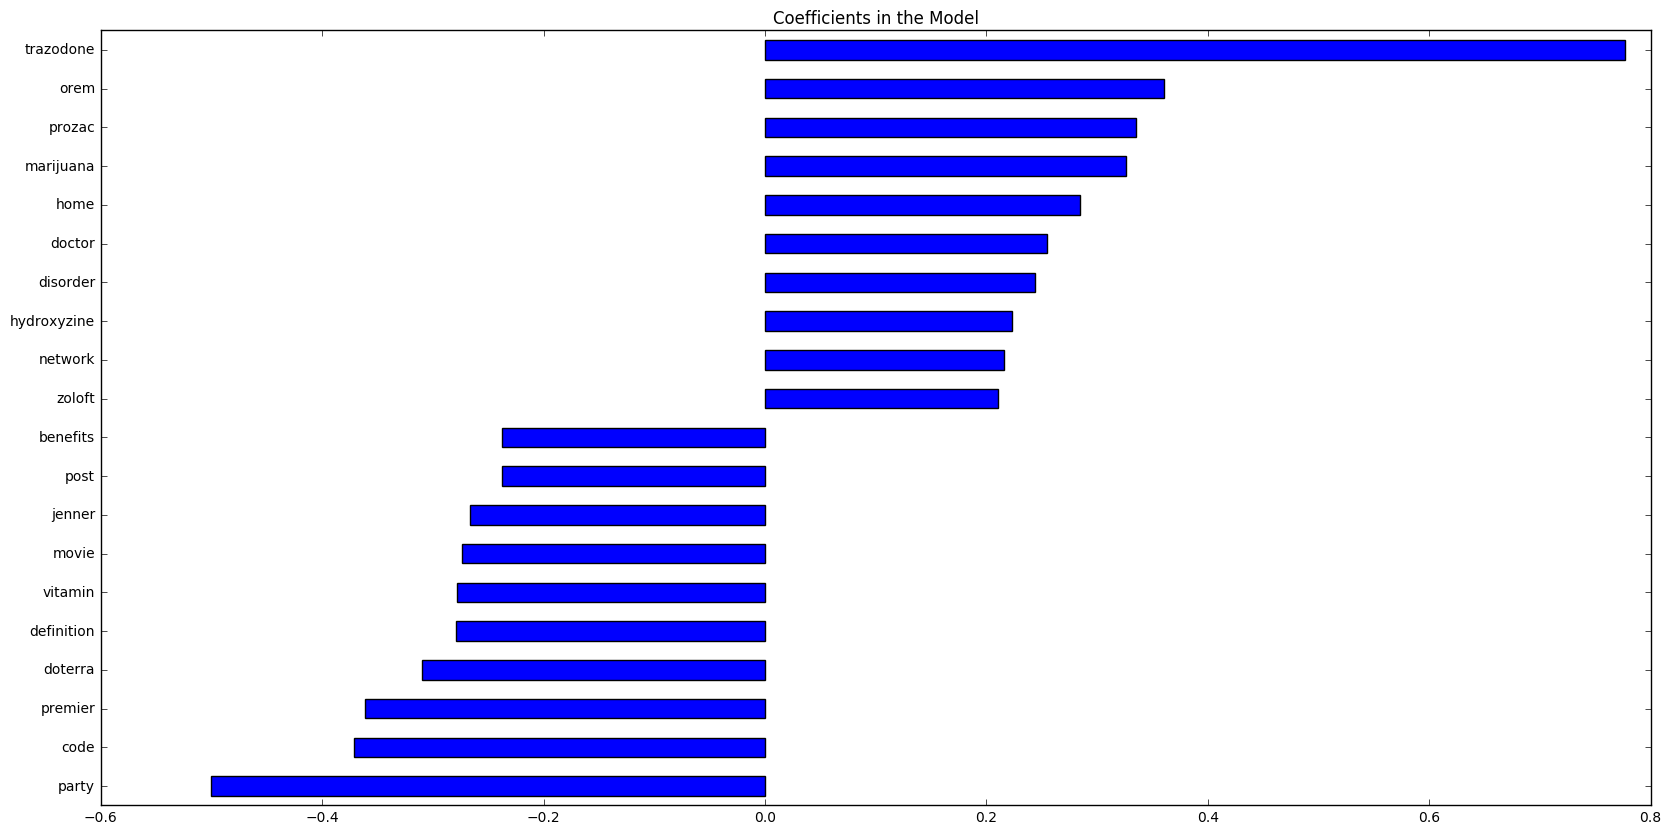

In [126]:
show_coefs(model,X)

This result is similar to the one we had with census data without insurance feature. For crude prevalence prediction insurance coverage doesn't appear to be meaningful giving information we've obtained with Google Trends

### Final results:

In [127]:
res  = pd.DataFrame.from_dict(results,orient = "index")
res.columns = ["r2"]
res

,r2
trends + census data for age-adj. prev.,0.756332
trends only for crude prev.,0.780834
trends + census data + insurance data for crude prev.,0.780617
trends + census data + insurance data for age-adj. prev.,0.770233
trends only for age-adj. prev.,0.759648
trends + census data for crude prev.,0.754798


Even though the scores are not exactly equal, we should take into account that difference in 0.03-0.04 cannot be statistically significant.

Thus, we conclude that neither census data nor insurance data didn't improve the prediction result due to the fact that this information was already included in some of the features we've extracted from Google trends.

But, if we had a limitation on a possible number of features we could use for our research we would include information about income since it is correlated with the target features and appeared to be significant.